# Train classifier to estimate analysis efficiency vs gen variable

- Actual training code in training.py
- Classifier based on sklearn. Default is GradientBoostedClassifier, 
    but can be specified at run time.

## Load libraries

In [1]:
import train as tn
reload(tn)

import plotting
reload(plotting)

import matplotlib.pyplot as plt
#plt.style.use('seaborn-ticks')
plt.style.use('seaborn-poster')
%matplotlib inline
#%matplotlib notebook

import numpy as np

from pprint import pprint

import os
import json
import importlib

Welcome to ROOTaaS 6.06/08


## Instantiate helper class

Data are read from ROOT trees and converted into pandas data frames.  
The loading function makes sure that all the needed columns have been read from the trees, otherwise it rebilds the data frame.


In [2]:
params= {}
# inputDir="/eos/user/m/musella/data/mod_dep_005"
params["dataDir"]="root://t3dcachedb03.psi.ch//pnfs/psi.ch/cms/trivcat/store/user/musella/mod_dep_005"
params["dataFname"] = "output_InsideAcceptance_125.root"
params["pfx"] = "genDiphotonDumper/trees/InsideAcceptance_125_13TeV"

params["inputDir"] = "."
params["inputName"] = "effFitter"
params["outDir"] = "."
params["outName"] = "effFitter_out"

params["ncats"] = 3
params["genBranches"] = ["genPt","genRapidity",
            "genJet2p5Pt0","genJet2p5Rapidity0",
            "genJet2p5Pt1","genJet2p5Rapidity1",
            "genJet2p5Pt2","genJet2p5Rapidity2",
            "genJet2p5Pt3","genJet2p5Rapidity3",
            "weight",
            "genNjets2p5"
           ]
params["recoBranches"] = ['recoPt','recoRapidity',"recoNjets2p5"]
params["rndseed"] = 9347865
params["rndseed2"] = 2315645

params["split_frac"] = 0.75
#split_params = {"train_size" : 0.75, "test_size" : 0.25, "random_state" : rndseed2, "stratify" : False }

params["load"] = True
params["forceMake"] = False

params["clean"] = []

params["classifiers"] = [ "class", "recoPt", "recoNjets2p5" ]
params["class"] = [  "sklearn.ensemble.GradientBoostingClassifier", 
                      dict(trainevts=100000,max_depth=5,learning_rate=0.2,n_estimators=100,
                          min_weight_fraction_leaf=1e-3)
                    ]

params["recoPt"] = [ "sklearn.ensemble.GradientBoostingClassifier",
                      dict(Xbr=['genPt','absGenRapidity'],
                          trainevts=100000,max_depth=7,learning_rate=0.1,n_estimators=500,
                          min_weight_fraction_leaf=1e-4)
                    ]

params["recoNjets2p5"] = [ "sklearn.ensemble.GradientBoostingClassifier",
                            dict(Xbr=['genJet2p5Pt0', 'genJet2p5Rapidity0',
                                    'genJet2p5Pt1', 'genJet2p5Rapidity1',
                                    'genJet2p5Pt2', 'genJet2p5Rapidity2',
                                    'genJet2p5Pt3', 'genJet2p5Rapidity3',
                                    'genPt','absGenRapidity'
                                ],#factorized=True,
                                trainevts=500000,max_depth=5,learning_rate=0.1,
                                n_estimators=100,min_weight_fraction_leaf=1e-4,
                                subsample=0.1,verbose=True)
                         ]
                      
params["defineBins"] = { 'recoPt' : dict(boundaries=[0,15,30,60,120,180,200]),
                         'recoNjets2p5' : dict(boundaries=[-0.5,1.5,2.5,3.5,4.5])
}


params["clean"] = ["class", "recoPt", "recoNjets2p5" ]
params["class"] = [  "classify.BinnedFitter", 
                      dict(trainevts=-1,bins=30,ranges=[(0,300),(0,30)]) ]

params["recoPt"] = [  "classify.BinnedFitter", 
                      dict(Xbr=['genPt','absGenRapidity'],includeClassProbs=False,
                           trainevts=-1,bins=180,ranges=[(0,300),(0,30)],addprobs=True) ]


params["classifiers"] = ["class", "recoPt"]

params_xgboost = {
    "outName" : "effFitter_xgboost",
    "clean": ["recoPt", "recoNjets2p5"],
    "classifiers": ["class", "recoPt", ],
    "class": ["xgboost.sklearn.XGBClassifier",
                { "trainevts" :-1, "max_depth" : 5,
                "learning_rate" : 0.2,"n_estimators" : 250,
                "min_child_weight" : 5e-4,
                "nthread" : 16,
                 "cvoptimize" : True,
                 "cv_params_grid" : { 
                    "max_depth" : [3, 5, 7, 10],
                    "learning_rate" : [0.05, 0.1, 0.2], "n_estimators" : [100,250,500],
                    "min_child_weight" : [1e-4, 5e-4, 1e-3],
                    "subsample" : [0.1, 0.2, 0.5, 1.]
                 },
                 "cv_nfolds" : 5, "cv_niter" : 100,
                }
                ],

    "recoPt": ["xgboost.sklearn.XGBClassifier",
          { "Xbr" : ["genPt","absGenRapidity"],
            "trainevts" :-1, "max_depth" : 5,
            "learning_rate" : 0.1,"n_estimators" : 500,
            "min_child_weight" : 1e-5,
            "nthread" : 16,
            "cvoptimize" : True,
            "cv_params_grid" : { 
                    "max_depth" : [5, 7, 10],
                    "learning_rate" : [0.05, 0.1, 0.2], "n_estimators" : [250,500,700,1000],
                    "min_child_weight" : [1e-4, 5e-4, 1e-3],
                    "subsample" : [0.1, 0.2, 0.5, 1.]
                 },
            "cv_nfolds" : 5, "cv_niter" : 100,      
          }
        ],
    "recoNjets2p5": ["xgboost.sklearn.XGBClassifier",
        { "Xbr" : ["genJet2p5Pt0", "genJet2p5Rapidity0",
                                    "genJet2p5Pt1", "genJet2p5Rapidity1",
                                    "genJet2p5Pt2", "genJet2p5Rapidity2",
                                    "genJet2p5Pt3", "genJet2p5Rapidity3",
                                    "genPt","absGenRapidity"
                                ],
            "trainevts" :-1, "max_depth" : 7,
            "learning_rate" : 0.1,"n_estimators" : 500,
            "min_child_weight" : 1e-5,
            "nthread" : 16 }
    ]
}

params["inputName"] = "effFitter_xgboost"

params.update(params_xgboost)

config_files = os.environ.get('my_train_config',None)
if config_files:
    for cfg in config_files.split(','):
        print("reading %s" % cfg)
        with open(cfg) as fin: 
            loadparams = json.loads(fin.read())
            params.update(loadparams)


pprint(params)

def runDefineBins(fitter,binsDef):
    for name,params in binsDef.iteritems(): made.defineBins(name,**params)

def loadOrMake():

    name = params["inputName"]
    load = params["load"]
    forceMake = params["forceMake"]
    
    make = False
    if load:
        onDisk = tn.IO.load(name, path=params["inputDir"], nodata=forceMake)
        pprint(onDisk)
        if not forceMake:
            pprint(onDisk.df.columns)
        pprint(onDisk.clfs)
        if onDisk.genBranches != params["genBranches"] or onDisk.recoBranches != params["recoBranches"]:
            make = True
        if onDisk.ncats != params["ncats"]:
            make = True
            load = False
    else:
        make = True

    if make or forceMake:
        if not load:
            made = tn.EfficiencyFitter(name)
        else:
            made = onDisk
        
        fileName = os.path.join(params["dataDir"],params["dataFname"])
        made.readData(ncats,genBranches,recoBranches,[(fileName,None,pfx)])
        
        print('shuffling dataset')
        np.random.seed(rndseed)
        made.df['random_index'] = np.random.permutation(range(made.df.index.size))
        made.df.sort_values(by='random_index',inplace=True)
        made.df.set_index('random_index',inplace=True)
        made.split_frac = split_frac
        
        print('defining bins')
        if not 'absGenRapidity' in made.df.columns:
            made.df['absGenRapidity'] = np.abs(made.df['genRapidity'])
        runDefineBins(params["defineBins"])
        
    else:
        made = onDisk
    
    made.cleanClfs(params["clean"])
    
    made.outdir = params["outDir"]
    made.name = params["outName"]
    return made

effFitter = loadOrMake()


{'class': ['xgboost.sklearn.XGBClassifier',
           {'cv_nfolds': 5,
            'cv_niter': 100,
            'cv_params_grid': {'learning_rate': [0.05, 0.1, 0.2],
                               'max_depth': [3, 5, 7, 10],
                               'min_child_weight': [0.0001, 0.0005, 0.001],
                               'n_estimators': [100, 250, 500],
                               'subsample': [0.1, 0.2, 0.5, 1.0]},
            'cvoptimize': True,
            'learning_rate': 0.2,
            'max_depth': 5,
            'min_child_weight': 0.0005,
            'n_estimators': 250,
            'nthread': 16,
            'trainevts': -1}],
 'classifiers': ['class', 'recoPt'],
 'clean': ['recoPt', 'recoNjets2p5'],
 'dataDir': 'root://t3dcachedb03.psi.ch//pnfs/psi.ch/cms/trivcat/store/user/musella/mod_dep_005',
 'dataFname': 'output_InsideAcceptance_125.root',
 'defineBins': {'recoNjets2p5': {'boundaries': [-0.5, 1.5, 2.5, 3.5, 4.5]},
                'recoPt': {'boundaries': [0

/mnt/t3nfs01/data01/shome/musella/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Index([u'absweight', u'class', u'genJet2p5Pt0', u'genJet2p5Pt1',
       u'genJet2p5Pt2', u'genJet2p5Pt3', u'genJet2p5Rapidity0',
       u'genJet2p5Rapidity1', u'genJet2p5Rapidity2', u'genJet2p5Rapidity3',
       u'genNjets2p5', u'genPt', u'genRapidity', u'recoNjets2p5', u'recoPt',
       u'recoRapidity', u'weight', u'absGenRapidity', u'recoPtBin',
       u'recoPtCat', u'recoNjets2p5Bin', u'recoNjets2p5Cat', u'class_prob_0',
       u'class_prob_1', u'class_prob_2', u'class_prob_3'],
      dtype='object')
{'class': XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=7,
       min_child_weight=0.0005, missing=nan, n_estimators=100, nthread=16,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.2)}


In [3]:
effFitter

## Train classifiers

In [4]:
#recoPts = filter(lambda x: "recoPt_prob" in x, effFitter.df.columns)
#rename = { x : x.replace("_prob","Cat_prob") for x in recoPts }
#effFitter.df.rename(columns=rename,inplace=True)

In [5]:
from sklearn.externals.joblib import Parallel, parallel_backend, register_parallel_backend

import ipyparallel as ipp
from ipyparallel.joblib import IPythonParallelBackend
rc = ipp.Client(profile='default')

view = rc.load_balanced_view()
register_parallel_backend('ipyparallel', lambda : IPythonParallelBackend(view=view),make_default=True)

In [6]:
##import sklearn.externals.joblib as joblib 
##
##help(joblib)

### Control plot functions

In [7]:
def naive_closure(df,column,first=0,logy=False):
    target = target_name(column)
    nstats = np.unique(df[target]).size
    print(target,nstats)
    
    pred_cols = map(lambda x: ("%s_prob_%d" % (target, x)), range(nstats) ) 
    
    trueh = np.histogram(df[target],np.arange(-1.5,nstats-0.5))[0].ravel()
    predh = np.array(df[pred_cols].sum(axis=0)).ravel()
    
    print(trueh,predh)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    true = ax.bar(np.arange(0,2*(nstats),2)[first:],trueh[first:],color='black')
    pred = ax.bar(np.arange(1,2*(nstats)+1,2)[first:],predh[first:],color='red')
    if logy:
        ax.set_yscale('log')
        
    plt.legend((true,pred),("true","predicted"))
    
    plt.show()

def control_plots(key,fitter):
    target = target_name(key)
    
    nclasses = len(fitter.clfs[key].classes_)
    columns = map(lambda x: "%s_prob_%d" % (target,x), xrange(nclasses) )
    
    columns = columns[1:]+columns[:1]
    
    df = fitter.df
    if fitter.split_frac > 0:
        first_train_evt = int(round(df.index.size*(1.-fitter.split_frac)))
        df = df[:first_train_evt]
    
    nrows = nclasses/3+1
    ncols = 3
    %time fitter.df.boxplot(by=target,column=columns,figsize=(7*ncols,7*nrows),layout=(nrows,ncols))
    
    %time plotting.scatter_hist(fitter.df,columns,figsize=(28,28))
    
    %time naive_closure(fitter.df,key,logy=True)
    %time naive_closure(fitter.df,key,first=1,logy=False)

###  make sure that the trained classifers have been evaluated

In [3]:
def target_name(key):
    postFix = ""
    if key != 'class':
        postFix = 'Cat' if not params[key][1].get('factorized',False) else 'Bin'
    return key+postFix 

clf_keys = filter(lambda x: x in effFitter.clfs.keys(),params["classifiers"])
     
for key in clf_keys:
    target = target_name(key)
    catKey = '%s_prob_0' % (target)
    if not catKey in effFitter.df.columns:
        print('running prediction for %s' % key)
        effFitter.runPrediction(target,effFitter.clfs[key])


effFitter.df.columns

NameError: name 'params' is not defined

### Run the actual training

In [ ]:
to_train = filter(lambda x: x not in effFitter.clfs.keys(), params["classifiers"])

for key in to_train:
    classifier,train_params = params[key]
    pack,cls = classifier.rsplit('.',1)
    classifier = getattr(importlib.import_module(pack),cls)
    print("Fitting %s" % key)
    print(classifier)
    print(train_params)
    if key == 'class':
        %time effFitter.fitClass(classifier=classifier,**train_params)
    else:
        %time effFitter.fitBins(key,classifier=classifier,**train_params)


Fitting recoPt
<class 'xgboost.sklearn.XGBClassifier'>
{'cvoptimize': True, 'learning_rate': 0.1, 'cv_nfolds': 5, 'trainevts': -1, 'n_estimators': 500, 'Xbr': ['genPt', 'absGenRapidity'], 'cv_niter': 100, 'nthread': 16, 'min_child_weight': 1e-05, 'cv_params_grid': {'n_estimators': [250, 500, 700, 1000], 'subsample': [0.1, 0.2, 0.5, 1.0], 'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [5, 7, 10], 'min_child_weight': [0.0001, 0.0005, 0.001]}, 'max_depth': 5}
cvoptimize True


In [2]:
effFitter

NameError: name 'effFitter' is not defined

## save output

In [ ]:
pprint(effFitter.clfs)
pprint(effFitter.df.columns)

In [ ]:
%time tn.IO.save(effFitter)

CPU times: user 9.89 s, sys: 38 ms, total: 9.93 s
Wall time: 9.93 s


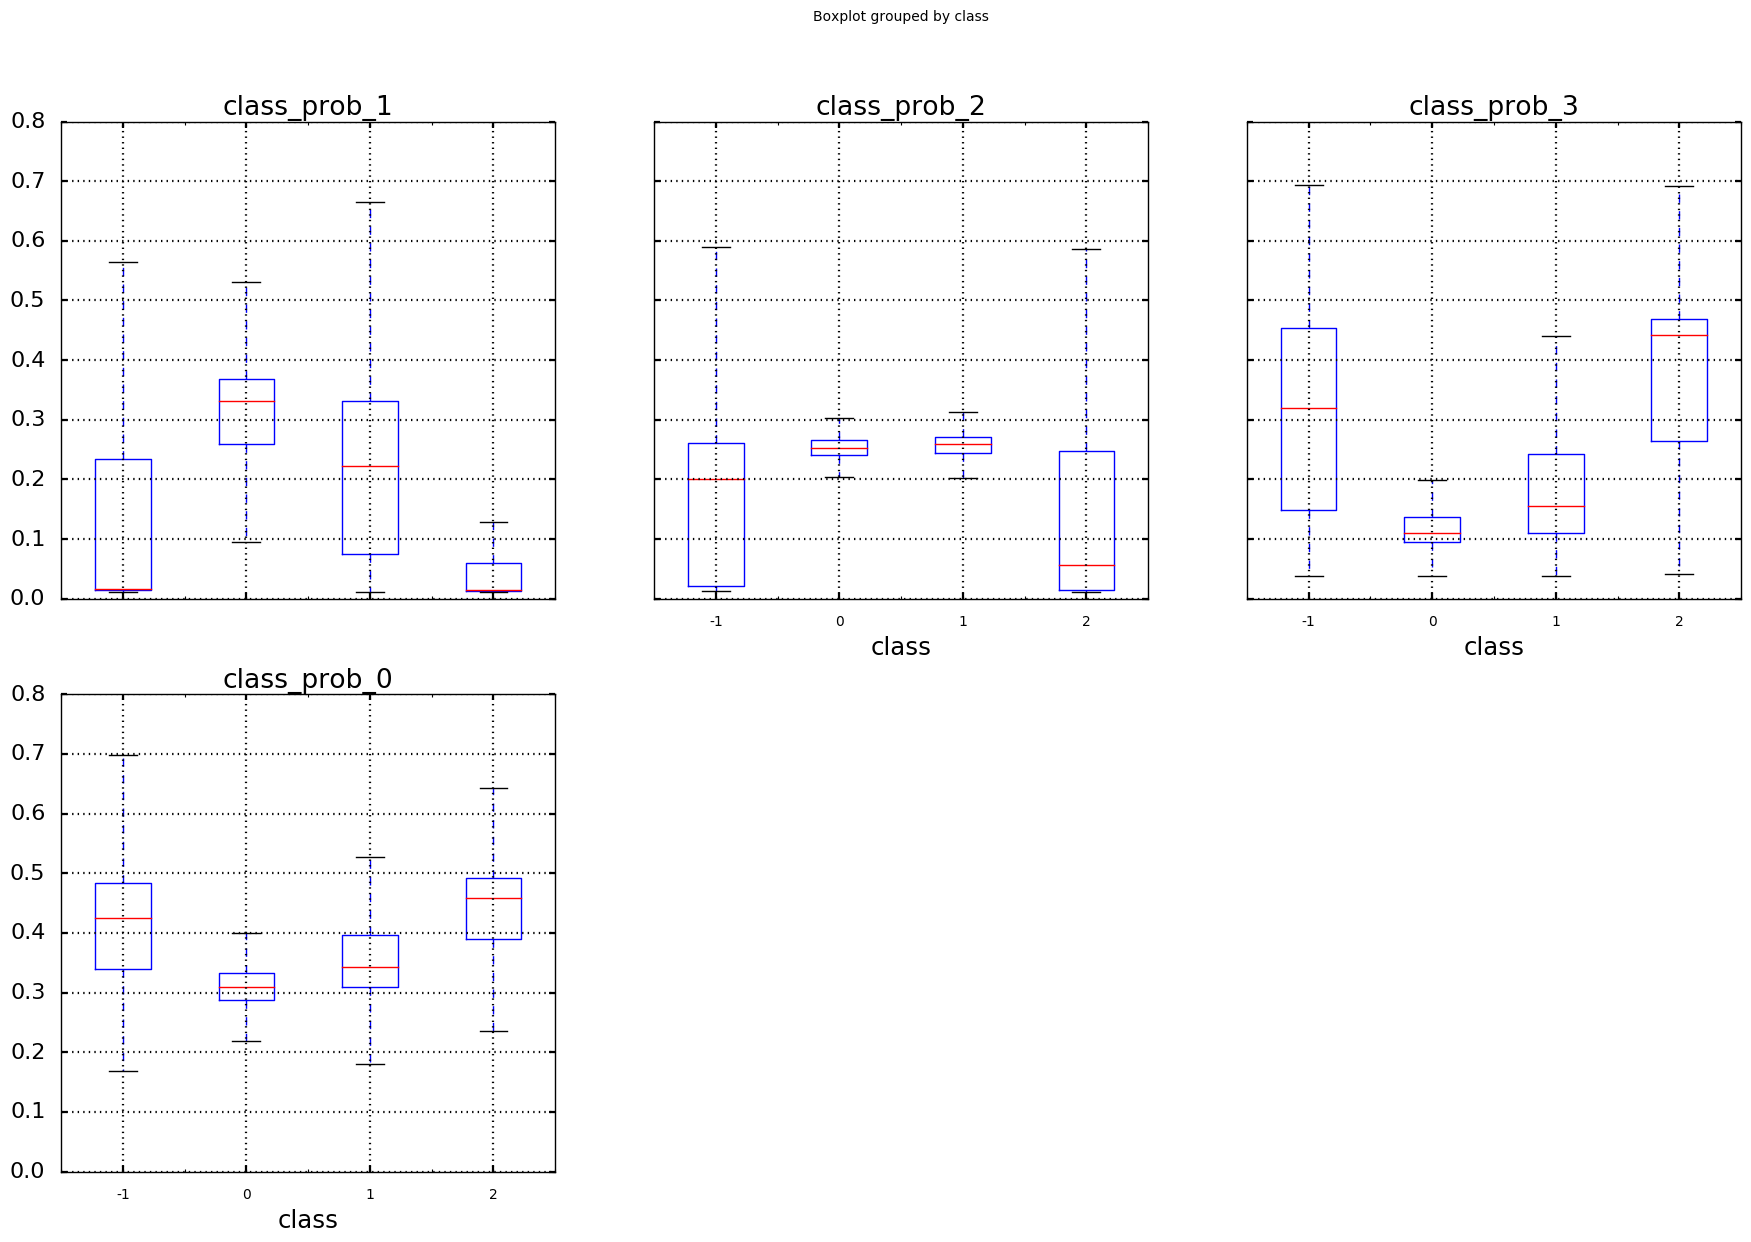

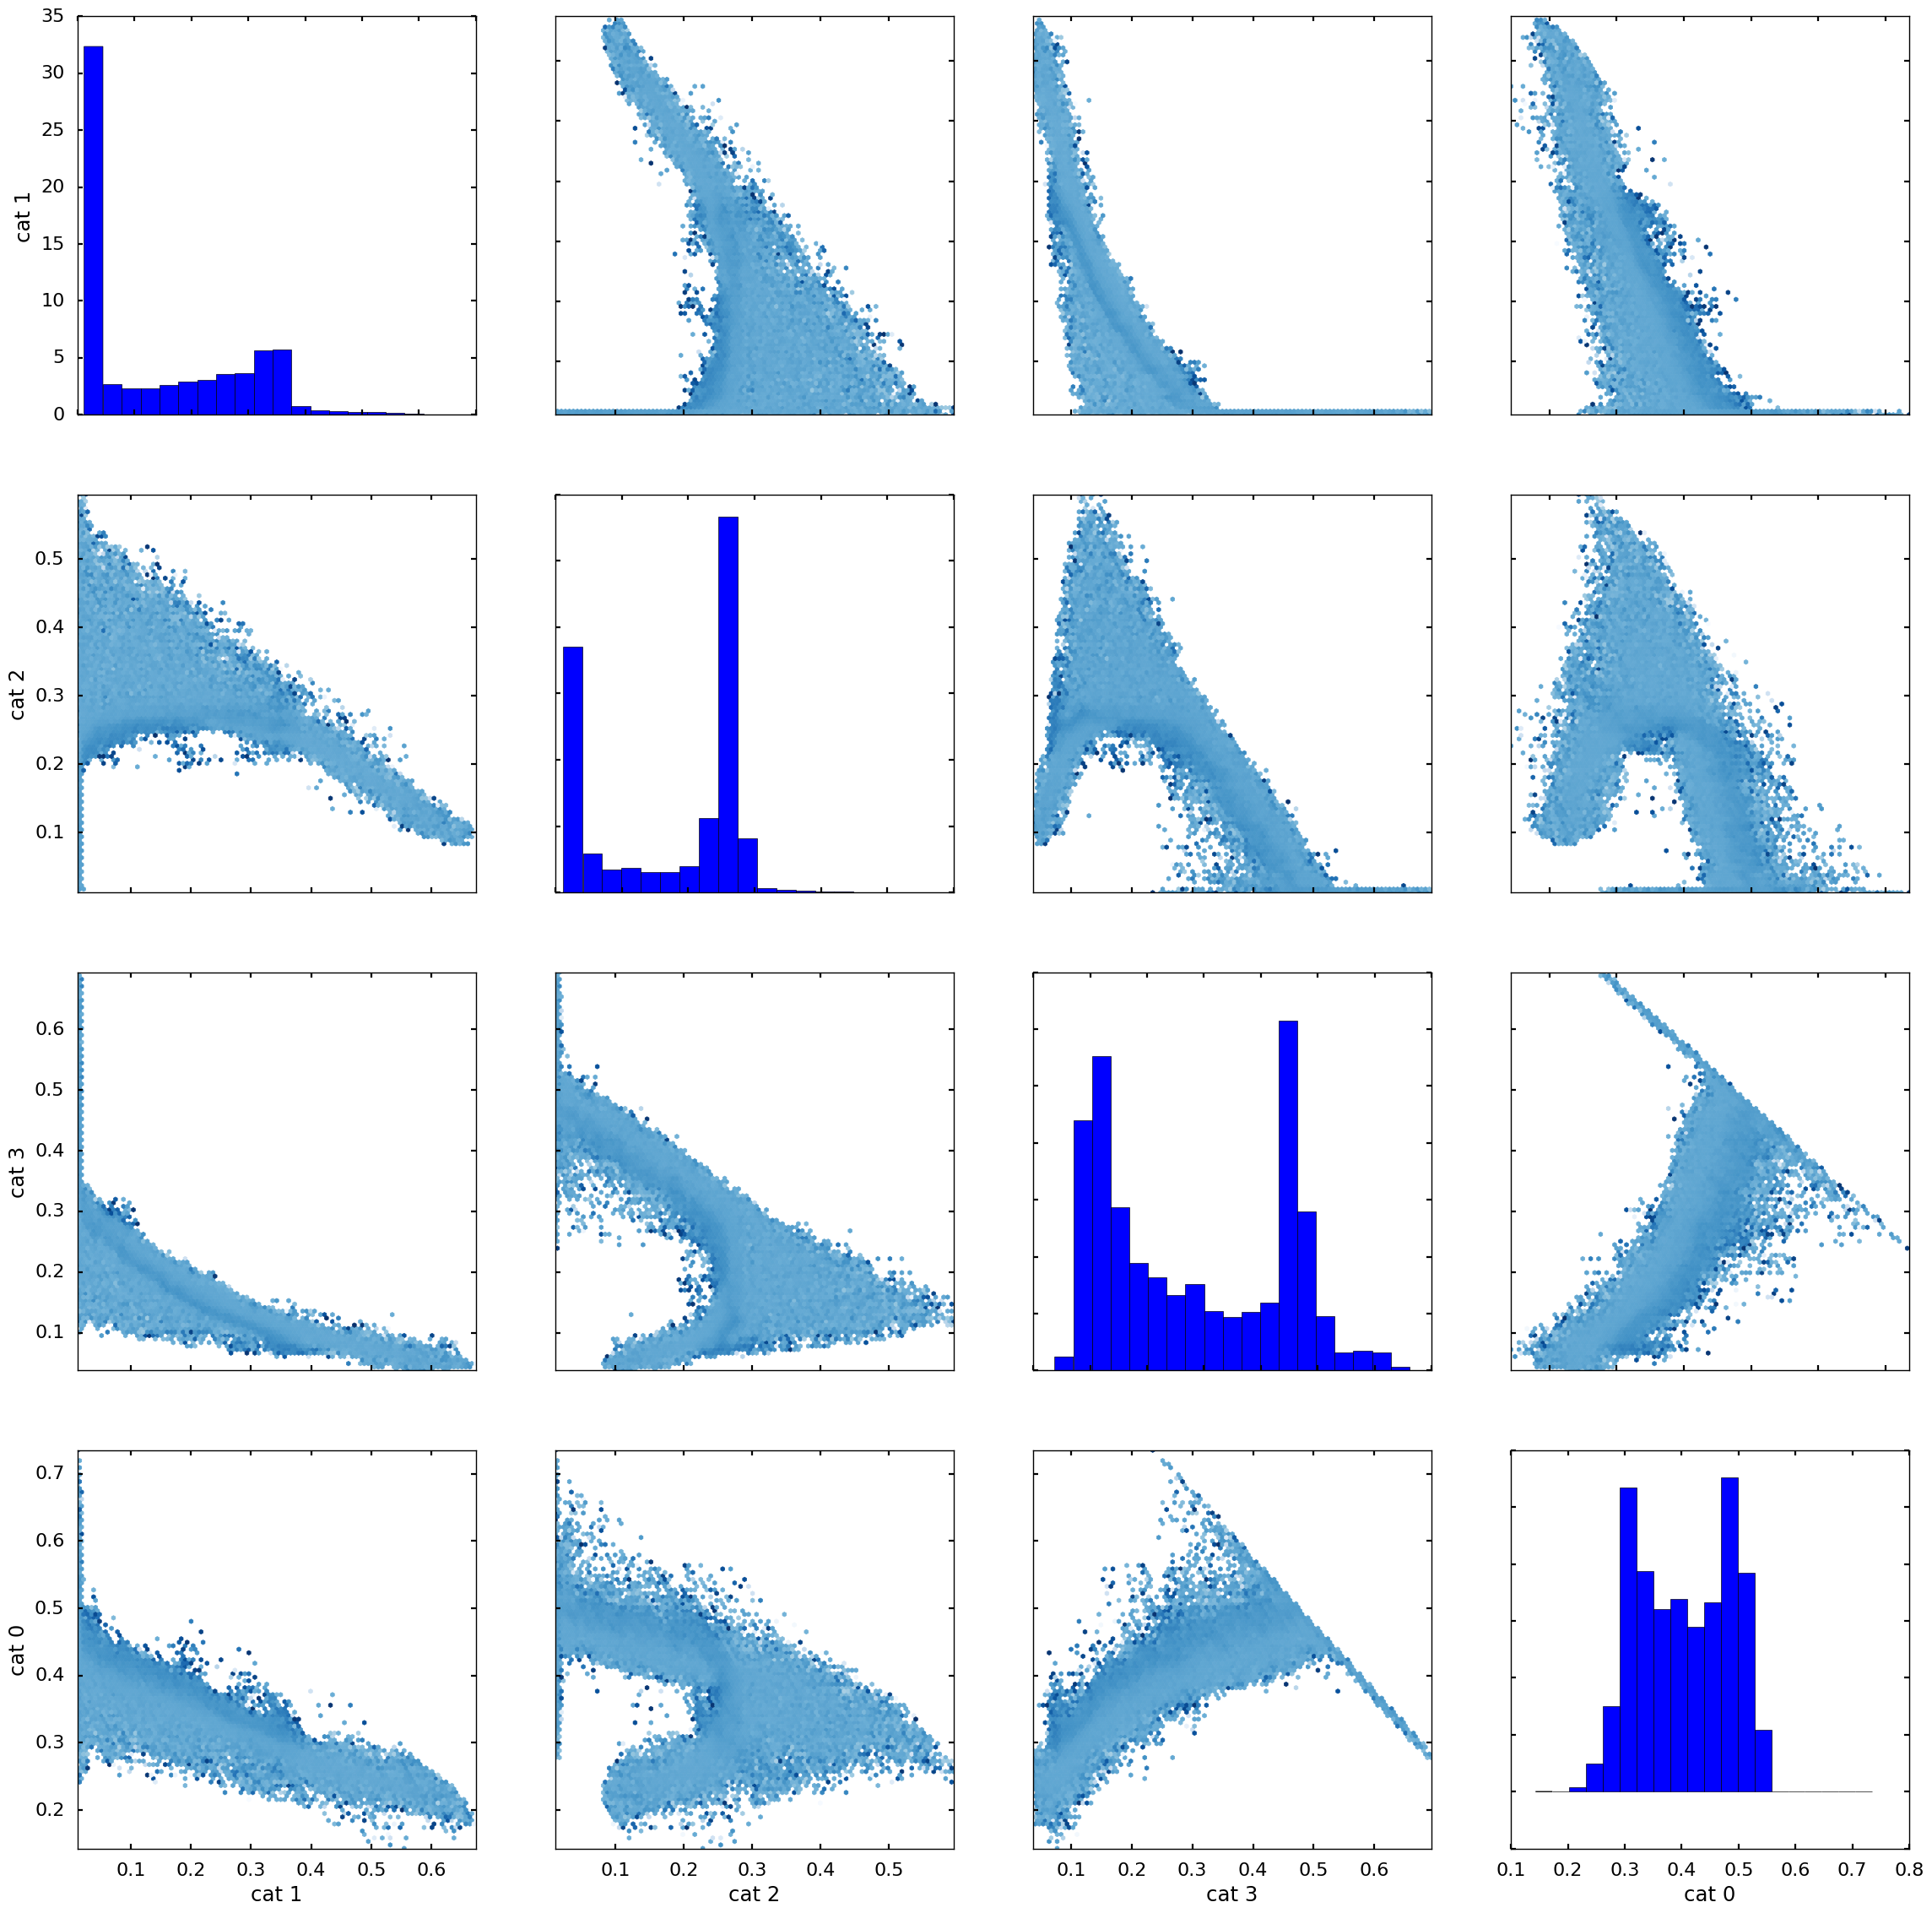

CPU times: user 1min 8s, sys: 1.12 s, total: 1min 9s
Wall time: 1min 9s
('class', 4)
(array([558201, 199025, 239432, 392746]), array([ 548905.6875 ,  208362.40625,  243564.84375,  389102.59375], dtype=float32))


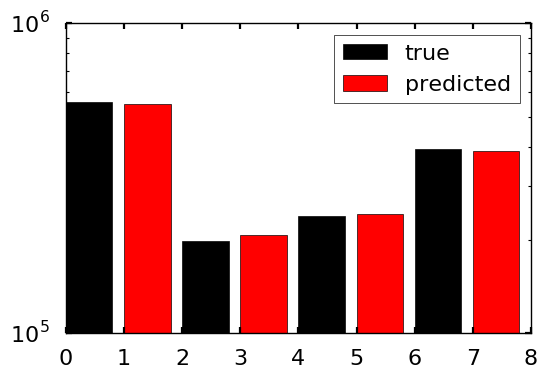

CPU times: user 936 ms, sys: 15 ms, total: 951 ms
Wall time: 945 ms
('class', 4)
(array([558201, 199025, 239432, 392746]), array([ 548905.6875 ,  208362.40625,  243564.84375,  389102.59375], dtype=float32))


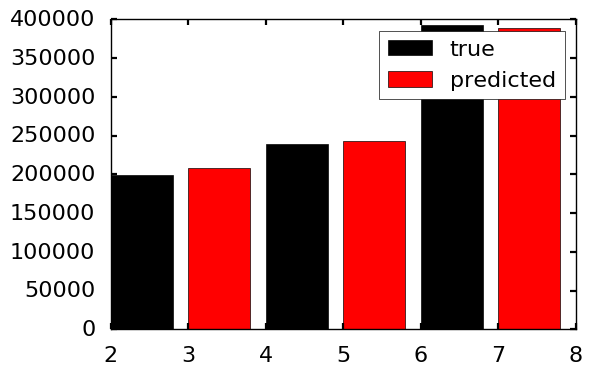

CPU times: user 665 ms, sys: 3 ms, total: 668 ms
Wall time: 664 ms


In [89]:
for key in params["classifiers"]:
    control_plots(key,effFitter)

In [13]:
effFitter.best_params

{'class': {'learning_rate': 0.05,
  'max_depth': 7,
  'min_child_weight': 0.0005,
  'n_estimators': 100,
  'subsample': 0.2}}

In [64]:
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

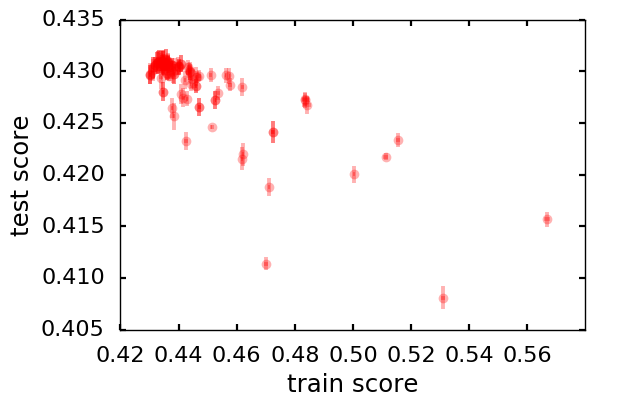

In [79]:
df_class_cv = pd.DataFrame( effFitter.cv_results['class'] )

plt.errorbar(x=df_class_cv['mean_train_score'],xerr=df_class_cv['std_train_score'],
             y=df_class_cv['mean_test_score'], yerr=df_class_cv['std_test_score'],
            ls='none',fmt='o',alpha=0.3,ms=7,color='red')

plt.xlabel('train score')
plt.ylabel('test score')

In [80]:
for col in  effFitter.cv_results['class']['params'][0].keys():
    df_class_cv[col] = np.array( list(map(lambda x: x[col], effFitter.cv_results['class']['params'])) )


<Container object of 3 artists>

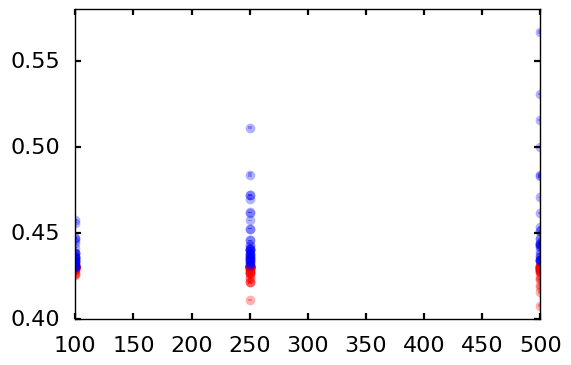

In [81]:
plt.errorbar(x=df_class_cv['n_estimators'],
             y=df_class_cv['mean_test_score'], yerr=df_class_cv['std_test_score'],
            ls='none',fmt='o',alpha=0.3,ms=7,color='red')

plt.errorbar(x=df_class_cv['n_estimators'],
             y=df_class_cv['mean_train_score'], yerr=df_class_cv['std_train_score'],
            ls='none',fmt='o',alpha=0.3,ms=7,color='blue')


<Container object of 3 artists>

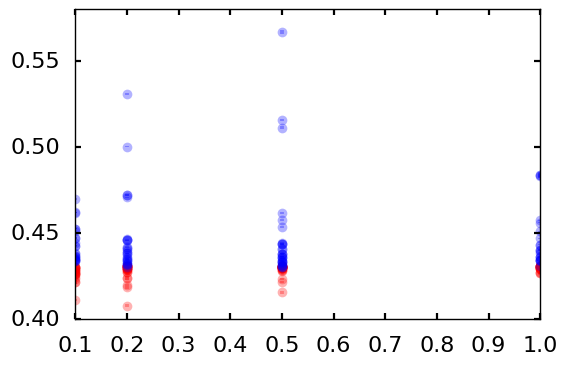

In [82]:
plt.errorbar(x=df_class_cv['subsample'],
             y=df_class_cv['mean_test_score'], yerr=df_class_cv['std_test_score'],
            ls='none',fmt='o',alpha=0.3,ms=7,color='red')

plt.errorbar(x=df_class_cv['subsample'],
             y=df_class_cv['mean_train_score'], yerr=df_class_cv['std_train_score'],
            ls='none',fmt='o',alpha=0.3,ms=7,color='blue')



<Container object of 3 artists>

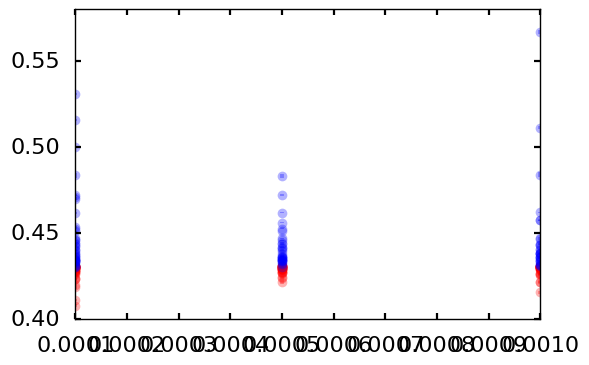

In [83]:
plt.errorbar(x=df_class_cv['min_child_weight'],
             y=df_class_cv['mean_test_score'], yerr=df_class_cv['std_test_score'],
            ls='none',fmt='o',alpha=0.3,ms=7,color='red')

plt.errorbar(x=df_class_cv['min_child_weight'],
             y=df_class_cv['mean_train_score'], yerr=df_class_cv['std_train_score'],
            ls='none',fmt='o',alpha=0.3,ms=7,color='blue')


<Container object of 3 artists>

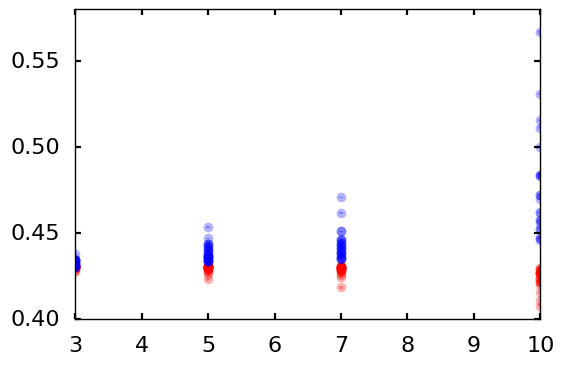

In [84]:
plt.errorbar(x=df_class_cv['max_depth'],
             y=df_class_cv['mean_test_score'], yerr=df_class_cv['std_test_score'],
            ls='none',fmt='o',alpha=0.3,ms=7,color='red')

plt.errorbar(x=df_class_cv['max_depth'],
             y=df_class_cv['mean_train_score'], yerr=df_class_cv['std_train_score'],
            ls='none',fmt='o',alpha=0.3,ms=7,color='blue')
